# ZIP CODE‑Level Home Price Forecasting & Material‑Decline Risk

**Stakeholder:** Mortgage lender (portfolio risk / underwriting)  
**Horizon:** 1 month ahead  

**Targets (supervised):**
1) **Regression:** predict next month home value (price level)  
2) **Classification (derived):** alert if next month return ≤ **‑1%** (“material decline”)

This notebook demonstrates clear business framing, leakage-safe preparation, multiple models (baseline + ARMA + ARIMA + SARIMA), evaluation against baseline, and a demo that works for any ZIP.

**Domain grounding sources (Independent Learning):**  
- [Zillow Research Data (ZHVI-style)]: (https://www.zillow.com/research/data/)  
- FHFA House Price Index (HPI): https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index.aspx


## 1) Business Understanding

Mortgage lenders are exposed to changes in collateral values. A ZIP-level forecast can support:
- underwriting adjustments (risk-based pricing / tighter requirements)
- portfolio monitoring (identify weakening ZIPs early)
- reserves and risk reporting

**Predictive question:** Using historical monthly home values, can we forecast next month’s value for each ZIP? From that forecast, can we flag when the next month is likely to drop by **≥ 1%**?

Because missing a true decline is costly, the alert logic leans toward **recall**.


In [33]:
# Imports & global settings (single import cell for reproducibility)
import warnings
import logging

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt


from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, precision_score, recall_score, fbeta_score

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# --- Warning & logging control (keeps notebook output clean) ---
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger("statsmodels").setLevel(logging.ERROR)

# Global settings
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)

%matplotlib inline


## 2) Data Understanding

The CSV is in a wide format (ZIP rows × monthly columns). I load the file, confirm the basic schema, then separate ID columns from date columns.


In [34]:
DATA_PATH = "zillow_data.csv"
raw = pd.read_csv(DATA_PATH)
raw.head(3)


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,...,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,444200.0,450000.0,455900.0,462100.0,468500.0,475300.0,482500.0,490200.0,498200.0,507200.0,516800.0,526300.0,535300.0,544500.0,553500.0,562400.0,571200.0,579800.0,588100.0,596300.0,604200.0,612200.0,620200.0,627700.0,634500.0,641000.0,647000.0,652700.0,658100.0,663300.0,668400.0,673400.0,678300.0,683200.0,688300.0,693300.0,698000.0,702400.0,706400.0,710200.0,714000.0,717800.0,721700.0,725700.0,729900.0,733400.0,735600.0,737200.0,739000.0,740900.0,742700.0,744400.0,746000.0,747200.0,748000.0,749000.0,750200.0,752300.0,...,775600.0,777800.0,775200.0,767900.0,764700.0,766100.0,764100.0,759700.0,754900.0,746200.0,737300.0,730800.0,729300.0,730200.0,730700.0,730000.0,730100.0,730100.0,731200.0,733900.0,735500.0,735400.0,734400.0,737500.0,737700.0,733700.0,734000.0,740300.0,744600.0,750500.0,760400.0,771800.0,780600.0,787900.0,794100.0,798900.0,802300.0,806100.0,810900.0,817400.0,826800.0,837900.0,848100.0,853800.0,856700.0,856600.0,854400.0,853000.0,856200.0,859700.0,863900.0,872900.0,883300.0,889500.0,892800,893600,891300,889900,891500,893000,893000,895000,901200,909400,915000,916700,917700,919800,925800,937100,948200,951000,952500,958600,966200,970400,973900,974700,972600,974300,980800,988000,994700,998700,997000,993700,991300,989200,991300,999100,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,215800.0,211100.0,205700.0,200900.0,196800.0,193600.0,191400.0,190400.0,190800.0,192700.0,196000.0,201300.0,207400.0,212200.0,214600.0,215100.0,213400.0,210200.0,206100.0,202100.0,198800.0,196100.0,194100.0,193400.0,193400.0,193100.0,192700.0,193000.0,193700.0,194800.0,196100.0,197800.0,199700.0,201900.0,204500.0,207800.0,211500.0,214900.0,217800.0,221100.0,224100.0,226700.0,228200.0,228500.0,227200.0,224900.0,221900.0,219100.0,216900.0,215400.0,214500.0,214600.0,215600.0,217000.0,218400.0,219600.0,220000.0,219100.0,216800.0,213100.0,208700.0,204000.0,199

In [35]:
# Identify ID columns vs time columns (YYYY-MM)
id_cols = [c for c in raw.columns if not str(c)[:4].isdigit()]
date_cols = [c for c in raw.columns if str(c)[:4].isdigit()]

dates = pd.to_datetime(date_cols, errors="coerce").to_period("M").to_timestamp()
valid = ~pd.isna(dates)
date_cols = list(pd.Series(date_cols)[valid].iloc[np.argsort(dates[valid])])
dates = pd.to_datetime(date_cols).to_period("M").to_timestamp()

print("ZIP rows:", raw.shape[0])
print("Monthly columns:", len(date_cols))
print("Date range:", dates.min().date(), "→", dates.max().date())


ZIP rows: 14723
Monthly columns: 265
Date range: 1996-04-01 → 2018-04-01


## 3) Data Preparation

I reshape wide → long so time splitting is straightforward. Then I create a chronological train/validation/test split and handle missingness with forward-fill that does not use future values.


In [36]:
# Wide → long reshape
long_df = raw.melt(id_vars=id_cols, value_vars=date_cols, var_name="date", value_name="value")
long_df["date"] = pd.to_datetime(long_df["date"], errors="coerce").dt.to_period("M").dt.to_timestamp()
long_df = long_df.dropna(subset=["date"])

# Standardize ZIP formatting
long_df = long_df.rename(columns={"RegionName":"zip"})
long_df["zip"] = long_df["zip"].astype(str).str.replace(r"\.0$", "", regex=True).str.zfill(5)

TRAIN_END = pd.Timestamp("2014-12-01")
VAL_END   = pd.Timestamp("2016-12-01")

long_df["split"] = np.where(long_df["date"] <= TRAIN_END, "train",
                    np.where(long_df["date"] <= VAL_END, "val", "test"))

long_df = long_df.sort_values(["zip","date"])
long_df.head()


,RegionID,zip,City,State,Metro,CountyName,SizeRank,date,value,split
5850,58196,01001,Agawam,MA,Springfield,Hampden,5851,1996-04-01,113100.0,train
20573,58196,01001,Agawam,MA,Springfield,Hampden,5851,1996-05-01,112800.0,train
35296,58196,01001,Agawam,MA,Springfield,Hampden,5851,1996-06-01,112600.0,train
50019,58196,01001,Agawam,MA,Springfield,Hampden,5851,1996-07-01,112300.0,train
64742,58196,01001,Agawam,MA,Springfield,Hampden,5851,1996-08-01,112100.0,train


In [37]:
# Train-only completeness (used for demo ZIP pool)
train_completeness = (long_df[long_df["split"].eq("train")]
                      .groupby("zip")["value"]
                      .apply(lambda s: s.notna().mean())
                      .sort_values(ascending=False))

zip_pool = train_completeness.head(200).index.tolist()
EXAMPLE_ZIP = "07462"
EXAMPLE_ZIP


'07462'

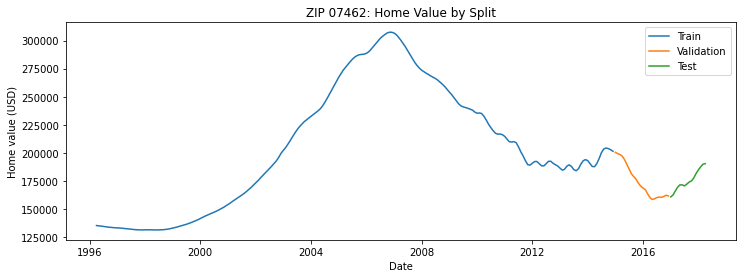

In [38]:
def split_series_by_zip(zip_code: str):
    """Return (train, val, test) series for the selected ZIP."""
    df = long_df[long_df["zip"].eq(str(zip_code).zfill(5))][["date","value","split"]].copy()
    df = df.set_index("date").sort_index()
    train = df[df["split"].eq("train")]["value"]
    val   = df[df["split"].eq("val")]["value"]
    test  = df[df["split"].eq("test")]["value"]
    return train, val, test

def ffill_no_leak_levels(train: pd.Series, val: pd.Series, test: pd.Series):
    """Forward-fill with leakage control: seed val with last train value, seed test with last val value."""
    train_f = train.ffill()
    val_f = pd.concat([train_f.iloc[[-1]], val]).ffill().iloc[1:] if not train_f.dropna().empty else val.ffill()
    test_f = pd.concat([val_f.iloc[[-1]], test]).ffill().iloc[1:] if not val_f.dropna().empty else test.ffill()
    return train_f, val_f, test_f

train_s, val_s, test_s = split_series_by_zip(EXAMPLE_ZIP)
train_f, val_f, test_f = ffill_no_leak_levels(train_s, val_s, test_s)

plt.figure(figsize=(12,4))
plt.plot(train_f.index, train_f.values, label="Train")
plt.plot(val_f.index, val_f.values, label="Validation")
plt.plot(test_f.index, test_f.values, label="Test")

plt.title(f"ZIP {EXAMPLE_ZIP}: Home Value by Split")
plt.xlabel("Date")               
plt.ylabel("Home value (USD)")     
plt.legend()
plt.show()

## 4) Time Series Exploration (Stationarity + ACF/PACF)

I check stationarity using ADF and KPSS and then visualize ACF/PACF on **diff(log(price))**, which is commonly used as a return-like stationary series. These steps are the diagnostics that lead into ARMA/ARIMA/SARIMA modeling.


In [39]:
# Train transforms
train_log = np.log(train_f.dropna())
train_dlog = train_log.diff().dropna()

adf_log_p = adfuller(train_log, autolag="AIC")[1]
adf_dlog_p = adfuller(train_dlog, autolag="AIC")[1]

try:
    kpss_log_p = kpss(train_log, regression="c", nlags="auto")[1]
except Exception:
    kpss_log_p = np.nan

try:
    kpss_dlog_p = kpss(train_dlog, regression="c", nlags="auto")[1]
except Exception:
    kpss_dlog_p = np.nan

pd.DataFrame({
    "Series": ["log(price)", "diff(log(price))"],
    "ADF p-value": [adf_log_p, adf_dlog_p],
    "KPSS p-value": [kpss_log_p, kpss_dlog_p],
})


,Series,ADF p-value,KPSS p-value
0,log(price),0.023021,0.01
1,diff(log(price)),0.665565,0.01


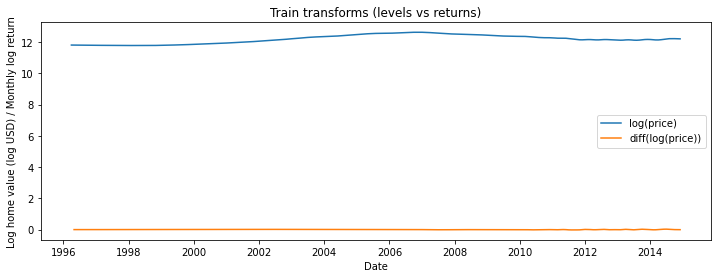

In [40]:
plt.figure(figsize=(12,4))
plt.plot(train_log.index, train_log.values, label="log(price)")
plt.plot(train_dlog.index, train_dlog.values, label="diff(log(price))")

plt.title("Train transforms (levels vs returns)")
plt.xlabel("Date")
plt.ylabel("Log home value (log USD) / Monthly log return")
plt.legend()
plt.show()


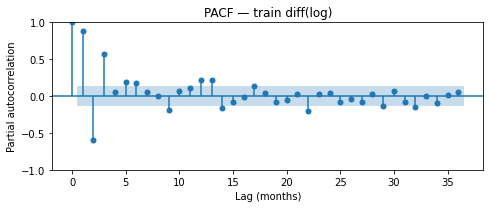

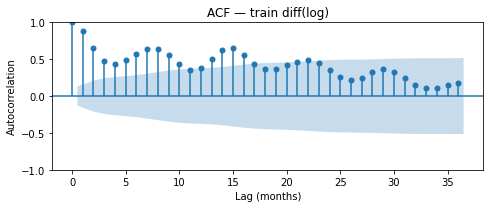

In [41]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

lags = min(36, len(train_dlog) - 1)

# --- PACF ---,
fig, ax = plt.subplots(figsize=(7,3))
plot_pacf(train_dlog, lags=lags, method="ywm", ax=ax)
ax.set_title("PACF — train diff(log)")
ax.set_xlabel("Lag (months)")
ax.set_ylabel("Partial autocorrelation")
plt.tight_layout()
plt.show()

# --- ACF ---
#plt.figure(figsize=(12,3))
fig, ax = plt.subplots(figsize=(7,3))
plot_acf(train_dlog, lags=lags, ax=ax)
ax.set_title("ACF — train diff(log)")
ax.set_xlabel("Lag (months)")
ax.set_ylabel("Autocorrelation")
plt.tight_layout()
plt.show()


ACF and PACF summarize how strongly the series relates to its own past values at different lags. The shaded band is the ~95% confidence interval; bars outside the band suggest statistically meaningful autocorrelation at that lag.

PACF: “Shows correlation between returns and a given lag after removing effects of shorter lags; helps choose AR order p.”

ACF: “Shows correlation between returns and past lags; helps choose MA order q.”


## 5) Modeling (Baseline → ARMA → ARIMA → SARIMA)

I start with a baseline model and then fit ARMA/ARIMA/SARIMA using small grids to keep runtime reasonable while still showing the full modeling process.


This decomposition breaks the (log) home value series into trend, seasonal, and residual components. It helps confirm whether there is a repeating annual pattern worth capturing with seasonal terms in a SARIMA model.


In [42]:
def evaluate_regression_aligned(y_true: pd.Series, y_pred: pd.Series) -> dict:
    """Align timestamps, drop missing pairs, compute MAE/RMSE."""
    df = pd.concat([y_true.rename("y"), y_pred.rename("yhat")], axis=1).dropna()
    return {
        "MAE": float(mean_absolute_error(df["y"], df["yhat"])),
        "RMSE": float(np.sqrt(mean_squared_error(df["y"], df["yhat"]))),
        "n": int(len(df))
    }

def baseline_static_forecast(train_f: pd.Series, val_f: pd.Series) -> pd.Series:
    """Multi-step baseline: repeat last observed train value across validation."""
    last = float(train_f.dropna().iloc[-1])
    return pd.Series(last, index=val_f.index)


These diagnostics check whether the model left systematic patterns behind. Ideally, residuals look like noise (no obvious trend) and the residual ACF does not show strong autocorrelation—otherwise the model may be missing structure.


In [43]:
# Baseline
baseline_pred = baseline_static_forecast(train_f, val_f)
baseline_val = evaluate_regression_aligned(val_f, baseline_pred)
baseline_val


{'MAE': 26870.833333333332, 'RMSE': 30642.18905365607, 'n': 24}

In [44]:
# ARMA grid on diff(log(price))
arma_grid = [(1,0,1), (1,0,2), (2,0,1)]
best_arma = None
best_arma_order = None
best_arma_pred = None

tr_log = np.log(train_f.dropna())
va_log = np.log(val_f.dropna())
dlog = tr_log.diff().dropna()

for order in arma_grid:
    try:
        m = ARIMA(dlog, order=order, enforce_stationarity=False, enforce_invertibility=False).fit(method_kwargs={"maxiter":50})
        pred_ret = pd.Series(m.forecast(steps=len(va_log)), index=va_log.index)
        pred_log = tr_log.iloc[-1] + pred_ret.cumsum()
        pred_price = np.exp(pred_log)

        met = evaluate_regression_aligned(val_f.loc[pred_price.index], pred_price)
        if best_arma is None or met["RMSE"] < best_arma["RMSE"]:
            best_arma = met
            best_arma_order = order
            best_arma_pred = pred_price
    except Exception:
        continue

best_arma_order, best_arma


((1, 0, 1), {'MAE': 25744.089797974768, 'RMSE': 30246.40358704504, 'n': 24})

In [45]:
# ARIMA grid on log(price)
arima_grid = [(0,1,1), (1,1,1), (1,1,2)]
best_arima = None
best_arima_order = None
best_arima_pred = None

for order in arima_grid:
    try:
        m = ARIMA(tr_log, order=order, enforce_stationarity=False, enforce_invertibility=False).fit(method_kwargs={"maxiter":50})
        pred_log = pd.Series(m.forecast(steps=len(va_log)), index=va_log.index)
        pred_price = np.exp(pred_log)

        met = evaluate_regression_aligned(val_f.loc[pred_price.index], pred_price)
        if best_arima is None or met["RMSE"] < best_arima["RMSE"]:
            best_arima = met
            best_arima_order = order
            best_arima_pred = pred_price
    except Exception:
        continue

best_arima_order, best_arima


((1, 1, 1), {'MAE': 20915.078136523032, 'RMSE': 24611.292250686114, 'n': 24})

In [46]:
# SARIMA grid on log(price) with yearly seasonality (s=12)
# Using simple_differencing=False ensures forecast is in log(level) space (safe to exp()).

sarima_grid = [
    ((0,1,1), (1,0,1,12)),
    ((1,1,1), (1,0,1,12)),
    ((1,1,2), (1,0,1,12)),
]

best_sarima = None
best_sarima_params = None
best_sarima_pred = None

for order, seas in sarima_grid:
    try:
        m = SARIMAX(tr_log, order=order, seasonal_order=seas,
                    enforce_stationarity=False, enforce_invertibility=False,
                    simple_differencing=False).fit(disp=False, maxiter=50)

        pred_log = pd.Series(m.forecast(steps=len(va_log)), index=va_log.index)
        pred_price = np.exp(pred_log)

        met = evaluate_regression_aligned(val_f.loc[pred_price.index], pred_price)
        if best_sarima is None or met["RMSE"] < best_sarima["RMSE"]:
            best_sarima = met
            best_sarima_params = (order, seas)
            best_sarima_pred = pred_price
    except Exception:
        continue

best_sarima_params, best_sarima


(((1, 1, 1), (1, 0, 1, 12)),
 {'MAE': 15633.456796442706, 'RMSE': 18214.075682119124, 'n': 24})

This chart compares the final selected model’s test forecasts against the actual values for the same months. The gap between the lines is the month-ahead forecast error the lender would experience if using the model for this ZIP.


In [47]:
# Validation comparison (shows whether complexity adds value vs baseline)
val_table = pd.DataFrame([
    {"Model": "Baseline (static)", "Val_RMSE": baseline_val["RMSE"], "Val_MAE": baseline_val["MAE"]},
    {"Model": f"ARMA {best_arma_order}", "Val_RMSE": best_arma["RMSE"], "Val_MAE": best_arma["MAE"]},
    {"Model": f"ARIMA {best_arima_order}", "Val_RMSE": best_arima["RMSE"], "Val_MAE": best_arima["MAE"]},
    {"Model": f"SARIMA {best_sarima_params[0]}×{best_sarima_params[1]}", "Val_RMSE": best_sarima["RMSE"], "Val_MAE": best_sarima["MAE"]},
]).sort_values("Val_RMSE").reset_index(drop=True)

val_table


,Model,Val_RMSE,Val_MAE
0,"SARIMA (1, 1, 1)×(1, 0, 1, 12)",18214.075682,15633.456796
1,"ARIMA (1, 1, 1)",24611.292251,20915.078137
2,"ARMA (1, 0, 1)",30246.403587,25744.089798
3,Baseline (static),30642.189054,26870.833333


## 6) Final Evaluation (Holdout Test)

I choose the best model from validation and evaluate on the holdout test with a rolling 1-step-ahead forecast for the last 24 months.


In [48]:
best_model = val_table.iloc[0]["Model"]

if best_model.startswith("SARIMA"):
    FINAL_FAMILY = "SARIMA"
    FINAL_PARAMS = {"order": best_sarima_params[0], "seasonal": best_sarima_params[1], "maxiter": 50}
elif best_model.startswith("ARIMA"):
    FINAL_FAMILY = "ARIMA"
    FINAL_PARAMS = {"order": best_arima_order, "maxiter": 50}
elif best_model.startswith("ARMA"):
    FINAL_FAMILY = "ARMA"
    FINAL_PARAMS = {"order": best_arma_order, "maxiter": 50}
else:
    FINAL_FAMILY = "Baseline"
    FINAL_PARAMS = {}

FINAL_FAMILY, FINAL_PARAMS


('SARIMA', {'order': (1, 1, 1), 'seasonal': (1, 0, 1, 12), 'maxiter': 50})

In [49]:
def rolling_one_step_forecast_price(train_price: pd.Series, test_price: pd.Series,
                                      family: str, params: dict, last_n: int = 24) -> pd.Series:
    """Rolling 1-step forecast on price levels. Fits a fresh model each step (simple + leakage-safe)."""
    test_price = test_price.dropna()
    if last_n is not None and len(test_price) > last_n:
        test_price = test_price.iloc[-last_n:]

    hist_log = np.log(train_price.dropna()).copy()
    test_log = np.log(test_price)
    preds = []

    for t in range(len(test_log)):
        if family == "SARIMA":
            m = SARIMAX(hist_log, order=params["order"], seasonal_order=params["seasonal"],
                        enforce_stationarity=False, enforce_invertibility=False,
                        simple_differencing=False).fit(disp=False, maxiter=params.get("maxiter", 50))
            next_log = float(m.forecast(steps=1).iloc[0])
        elif family == "ARIMA":
            m = ARIMA(hist_log, order=params["order"],
                      enforce_stationarity=False, enforce_invertibility=False).fit(method_kwargs={"maxiter":params.get("maxiter", 50)})
            next_log = float(m.forecast(steps=1).iloc[0])
        elif family == "ARMA":
            dlog = hist_log.diff().dropna()
            m = ARIMA(dlog, order=params["order"],
                      enforce_stationarity=False, enforce_invertibility=False).fit(method_kwargs={"maxiter":params.get("maxiter", 50)})
            ret_hat = float(m.forecast(steps=1).iloc[0])
            next_log = float(hist_log.iloc[-1] + ret_hat)
        else:
            next_log = float(hist_log.iloc[-1])

        preds.append(np.exp(next_log))
        hist_log = pd.concat([hist_log, test_log.iloc[[t]]])

    return pd.Series(preds, index=test_price.index)

trainval = pd.concat([train_f, val_f]).sort_index()
test_pred = rolling_one_step_forecast_price(trainval, test_f, FINAL_FAMILY, FINAL_PARAMS, last_n=24)
test_y = test_f.dropna().loc[test_pred.index]

test_metrics = evaluate_regression_aligned(test_y, test_pred)
test_metrics


{'MAE': 841.4162859339558, 'RMSE': 991.836886793269, 'n': 16}

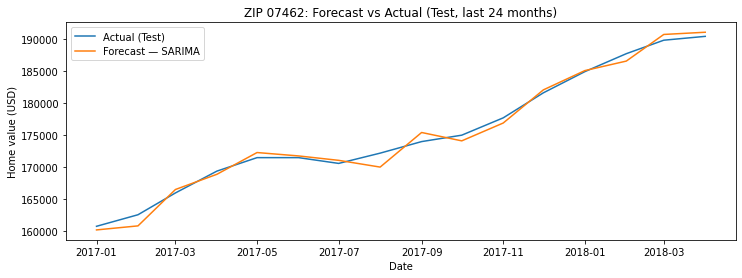

In [50]:
plt.figure(figsize=(12,4))
plt.plot(test_y.index, test_y.values, label="Actual (Test)")
plt.plot(test_pred.index, test_pred.values, label=f"Forecast — {FINAL_FAMILY}")
plt.title(f"ZIP {EXAMPLE_ZIP}: Forecast vs Actual (Test, last 24 months)")
plt.xlabel("Date")               
plt.ylabel("Home value (USD)")
plt.legend()
plt.show()


This chart shows rolling 12‑month volatility of monthly returns. Higher volatility periods tend to be riskier for lenders because prices can move more sharply, so forecast error and decline risk can increase in these regimes.


In [51]:
# Residual diagnostics: if p-values are small, residuals may still be autocorrelated
trainval_log = np.log(trainval.dropna())

if FINAL_FAMILY == "SARIMA":
    fitted = SARIMAX(trainval_log, order=FINAL_PARAMS["order"], seasonal_order=FINAL_PARAMS["seasonal"],
                     enforce_stationarity=False, enforce_invertibility=False,
                     simple_differencing=False).fit(disp=False, maxiter=FINAL_PARAMS.get("maxiter", 50))
elif FINAL_FAMILY == "ARIMA":
    fitted = ARIMA(trainval_log, order=FINAL_PARAMS["order"],
                   enforce_stationarity=False, enforce_invertibility=False).fit(method_kwargs={"maxiter":FINAL_PARAMS.get("maxiter", 50)})
else:
    fitted = None

if fitted is not None:
    resid = pd.Series(fitted.resid).dropna()
    acorr_ljungbox(resid, lags=[12,24], return_df=True)
else:
    print("Residual diagnostics skipped for baseline.")


## 7) Material Decline Alert (≥1% Drop)

I convert the regression outputs into a simple alert: next-month return ≤ ‑1%. The alert threshold is tuned on validation to emphasize recall via the F2 score.


In [52]:
TAU = -0.01  # -1% material decline

val_ret = val_f.pct_change().dropna()
y_true = (val_ret <= TAU).astype(int)

if FINAL_FAMILY == "SARIMA":
    val_pred_price = best_sarima_pred
elif FINAL_FAMILY == "ARIMA":
    val_pred_price = best_arima_pred
else:
    val_pred_price = best_arma_pred

pred_ret = (val_pred_price / val_f.shift(1) - 1).dropna()
cls_df = pd.concat([y_true.rename("y"), pred_ret.rename("pred_ret")], axis=1).dropna()

thresholds = np.linspace(-0.05, 0.02, 60)
best_thr, best_f2 = None, -1
for thr in thresholds:
    yhat = (cls_df["pred_ret"] <= thr).astype(int)
    f2 = fbeta_score(cls_df["y"], yhat, beta=2, zero_division=0)
    if f2 > best_f2:
        best_f2, best_thr = f2, float(thr)

yhat_best = (cls_df["pred_ret"] <= best_thr).astype(int)
precision = precision_score(cls_df["y"], yhat_best, zero_division=0)
recall = recall_score(cls_df["y"], yhat_best, zero_division=0)
cm = confusion_matrix(cls_df["y"], yhat_best)

best_thr, {"precision": precision, "recall": recall, "F2": best_f2}, cm


(0.011694915254237291,
 {'precision': 0.6, 'recall': 0.2727272727272727, 'F2': 0.3061224489795918},
 array([[10,  2],
        [ 8,  3]]))

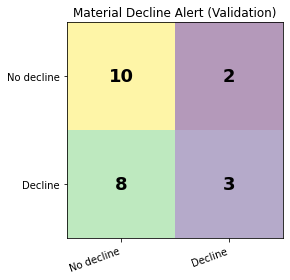

In [53]:
plt.figure(figsize=(5,4))
plt.imshow(cm, alpha=0.4)
plt.title("Material Decline Alert (Validation)")
plt.xticks([0,1],["No decline","Decline"], rotation=20, ha="right")
plt.yticks([0,1],["No decline","Decline"])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j,i,str(v),
             ha="center",va="center",
            fontsize=18, fontweight="bold")
plt.tight_layout()
plt.show()


## ZIP forecast demo (choose any ZIP)

The dataset contains thousands of ZIP codes. The workflow below lets you pick a ZIP code and generate:

- Actual vs forecasted prices (test period)
- MAE / RMSE by model (Baseline → ARMA → ARIMA → SARIMA)
- A 1-month-ahead “material decline” flag (forecasted return ≤ -1%)

This is designed for quick, repeatable demos. Change `ZIP_CODE` and re-run the next cell.


ZIP 60659 | Material-decline threshold: -1%
Decline alert (SARIMA signal) — Precision: 0.000 | Recall: 0.000 | F1: 0.000
Confusion matrix [[TN, FP],[FN, TP]]:
 [[15]]


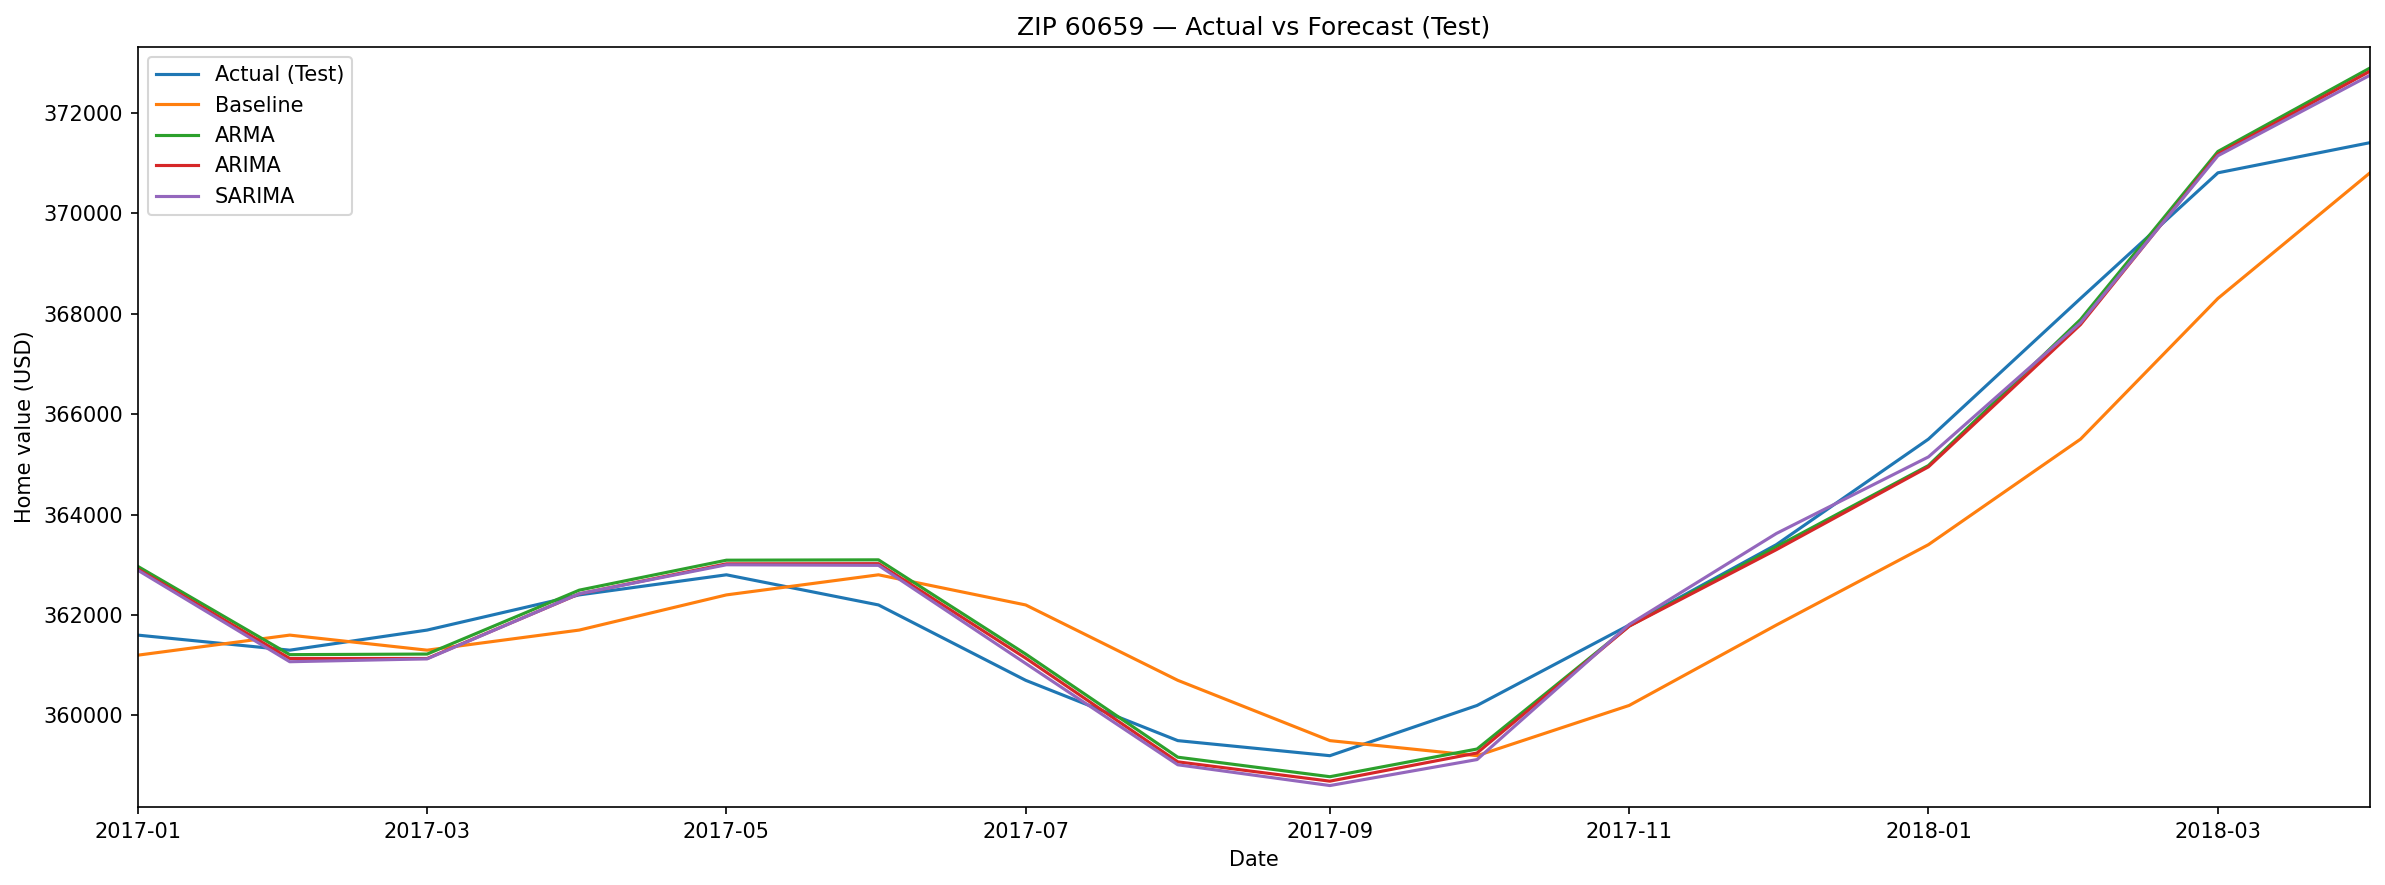

,model,MAE,RMSE,n
0,"SARIMA(1, 1, 1)x(1, 0, 1, 12) on log",521.617679,656.538703,16
1,"ARIMA(1, 1, 1) on log",525.750766,664.834330,16
2,"ARMA(1, 1) on diff(log)",516.949359,668.943555,16
3,Baseline (persistence),1125.000000,1373.408169,16


In [54]:
# --- ZIP forecast demo (choose any ZIP) ---
# Produces:
# 1) Actual vs Forecast (Test) for Baseline → ARMA → ARIMA → SARIMA
# 2) MAE/RMSE by model (per ZIP)
# 3) A simple “material decline” alert: predicted next-month return <= TAU

def _align_drop(y_true, y_pred):
    """Align on timestamp and drop missing pairs."""
    return pd.concat([y_true.rename("y"), y_pred.rename("yhat")], axis=1).dropna()

def evaluate_regression_aligned(y_true, y_pred):
    """Compute MAE/RMSE after aligning timestamps and dropping missing pairs."""
    df = _align_drop(y_true, y_pred)
    return {
        "MAE": float(mean_absolute_error(df["y"], df["yhat"])),
        "RMSE": float(np.sqrt(mean_squared_error(df["y"], df["yhat"]))),
        "n": int(len(df))
    }

def split_series_by_zip(zip_code):
    """Return raw (train, val, test) price series for one ZIP."""
    z = str(zip_code).zfill(5)
    df = long_df[long_df["zip"].eq(z)][["date", "value", "split"]].copy()
    df = df.set_index("date").sort_index()
    train = df[df["split"].eq("train")]["value"]
    val   = df[df["split"].eq("val")]["value"]
    test  = df[df["split"].eq("test")]["value"]
    return train, val, test

def ffill_no_leak_levels(train, val, test):
    """Forward-fill without leaking future values into earlier splits."""
    train_f = train.ffill()

    if not train_f.dropna().empty:
        val_f = pd.concat([train_f.dropna().iloc[[-1]], val]).ffill().iloc[1:]
    else:
        val_f = val.ffill()

    if not val_f.dropna().empty:
        test_f = pd.concat([val_f.dropna().iloc[[-1]], test]).ffill().iloc[1:]
    else:
        test_f = test.ffill()

    return train_f, val_f, test_f

def persistence_forecast_test(val, test):
    """Baseline for test: predict each month as the previous month’s actual value."""
    seed = val.dropna().iloc[[-1]] if not val.dropna().empty else pd.Series([], dtype=float)
    combo = pd.concat([seed, test]).sort_index()
    preds = combo.shift(1).iloc[1:]
    preds.index = test.index
    return preds

def rolling_one_step_arima_log(train_log, test_log, order):
    """Walk-forward 1-step forecasts in log space for ARIMA."""
    history = train_log.copy()
    preds = []
    for t in range(len(test_log)):
        m = ARIMA(history, order=order, enforce_stationarity=False, enforce_invertibility=False).fit()
        preds.append(float(m.forecast(steps=1).iloc[0]))
        history = pd.concat([history, test_log.iloc[[t]]])
    return pd.Series(preds, index=test_log.index)

def rolling_one_step_sarima_log(train_log, test_log, order, seasonal_order):
    """Walk-forward 1-step forecasts in log space for SARIMA."""
    history = train_log.copy()
    preds = []
    for t in range(len(test_log)):
        m = SARIMAX(
            history,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        preds.append(float(m.forecast(steps=1).iloc[0]))
        history = pd.concat([history, test_log.iloc[[t]]])
    return pd.Series(preds, index=test_log.index)

def rolling_one_step_arma_log(train_log, test_log, order_pq):
    """Walk-forward 1-step forecasts for ARMA on diff(log), integrated back to log levels."""
    p, q = order_pq
    history_log = train_log.copy()
    preds = []
    for t in range(len(test_log)):
        dlog = history_log.diff().dropna()
        m = ARIMA(dlog, order=(p, 0, q), enforce_stationarity=False, enforce_invertibility=False).fit()
        pred_dlog = float(m.forecast(steps=1).iloc[0])
        pred_log = float(history_log.iloc[-1]) + pred_dlog
        preds.append(pred_log)
        history_log = pd.concat([history_log, test_log.iloc[[t]]])
    return pd.Series(preds, index=test_log.index)

def _grid_search_on_val(train_log, val_log, family, arima_pdq=None, sarima_specs=None, arma_pq=None, metric="RMSE"):
    """Small grid search on validation to pick a reasonable config for ONE ZIP."""
    arima_pdq = arima_pdq or []
    sarima_specs = sarima_specs or []
    arma_pq = arma_pq or []

    best = {"family": family, "spec": None, metric: np.inf}

    if family == "ARIMA":
        for spec in arima_pdq:
            try:
                pred_val_log = rolling_one_step_arima_log(train_log, val_log, order=spec)
                m = evaluate_regression_aligned(np.exp(val_log), np.exp(pred_val_log))[metric]
                if m < best[metric]:
                    best.update({"spec": spec, metric: m})
            except Exception:
                continue

    elif family == "SARIMA":
        for order, seas in sarima_specs:
            try:
                pred_val_log = rolling_one_step_sarima_log(train_log, val_log, order=order, seasonal_order=seas)
                m = evaluate_regression_aligned(np.exp(val_log), np.exp(pred_val_log))[metric]
                if m < best[metric]:
                    best.update({"spec": (order, seas), metric: m})
            except Exception:
                continue

    elif family == "ARMA":
        for pq in arma_pq:
            try:
                pred_val_log = rolling_one_step_arma_log(train_log, val_log, order_pq=pq)
                m = evaluate_regression_aligned(np.exp(val_log), np.exp(pred_val_log))[metric]
                if m < best[metric]:
                    best.update({"spec": pq, metric: m})
            except Exception:
                continue

    return best

def run_zip_demo(zip_code, tau=-0.01, tune_on_val=True, show_plot=True):
    """Run Baseline → ARMA → ARIMA → SARIMA for a ZIP and return a comparison table."""
    zip_code = str(zip_code).zfill(5)
    train, val, test = split_series_by_zip(zip_code)
    train_f, val_f, test_f = ffill_no_leak_levels(train, val, test)

    train_log = np.log(train_f.dropna())
    val_log   = np.log(val_f.dropna())
    test_log  = np.log(test_f.dropna())

    # Require enough history for seasonal signal
    if len(train_log) < 36 or len(val_log) < 12 or len(test_log) < 6:
        raise ValueError(f"ZIP {zip_code}: not enough data (train={len(train_log)}, val={len(val_log)}, test={len(test_log)})")

    # Defaults
    arma_best = (1, 1)
    arima_best = (1, 1, 1)
    sarima_best = ((1, 1, 1), (1, 0, 1, 12))

    if tune_on_val:
        arima_grid = [(0,1,1), (1,1,0), (1,1,1), (2,1,1)]
        sarima_grid = [((1,1,1), (1,0,1,12)),
                       ((1,1,0), (1,0,1,12)),
                       ((0,1,1), (1,0,1,12))]
        arma_grid = [(1,0), (1,1), (2,1)]

        arma_pick = _grid_search_on_val(train_log, val_log, "ARMA", arma_pq=arma_grid)
        arima_pick = _grid_search_on_val(train_log, val_log, "ARIMA", arima_pdq=arima_grid)
        sarima_pick = _grid_search_on_val(train_log, val_log, "SARIMA", sarima_specs=sarima_grid)

        if arma_pick["spec"] is not None:
            arma_best = arma_pick["spec"]
        if arima_pick["spec"] is not None:
            arima_best = arima_pick["spec"]
        if sarima_pick["spec"] is not None:
            sarima_best = sarima_pick["spec"]

    sar_order, sar_seas = sarima_best

    y_test = np.exp(test_log)

    # Baseline
    pred_base = persistence_forecast_test(val_f, test_f).reindex(y_test.index)

    # Walk-forward forecasts on test using train+val history
    trainval_log = pd.concat([train_log, val_log]).sort_index()
    pred_log_arma  = rolling_one_step_arma_log(trainval_log, test_log, order_pq=arma_best)
    pred_log_arima = rolling_one_step_arima_log(trainval_log, test_log, order=arima_best)
    pred_log_sar   = rolling_one_step_sarima_log(trainval_log, test_log, order=sar_order, seasonal_order=sar_seas)

    pred_arma  = np.exp(pred_log_arma)
    pred_arima = np.exp(pred_log_arima)
    pred_sar   = np.exp(pred_log_sar)

    rows = [
        {"model": "Baseline (persistence)", **evaluate_regression_aligned(y_test, pred_base)},
        {"model": f"ARMA{arma_best} on diff(log)", **evaluate_regression_aligned(y_test, pred_arma)},
        {"model": f"ARIMA{arima_best} on log", **evaluate_regression_aligned(y_test, pred_arima)},
        {"model": f"SARIMA{sar_order}x{sar_seas} on log", **evaluate_regression_aligned(y_test, pred_sar)},
    ]
    comp = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)

    # Material-decline alert (simple rule)
    actual_ret = y_test.pct_change().dropna()
    y_true = (actual_ret <= tau).astype(int)

    pred_ret = (pred_sar / y_test.shift(1) - 1).dropna()
    aligned = pd.concat([y_true.rename("y_true"), pred_ret.rename("pred_ret")], axis=1).dropna()
    y_pred = (aligned["pred_ret"] <= tau).astype(int)

    prec = precision_score(aligned["y_true"], y_pred, zero_division=0)
    rec  = recall_score(aligned["y_true"], y_pred, zero_division=0)
    f1   = fbeta_score(aligned["y_true"], y_pred, beta=1, zero_division=0)
    cm   = confusion_matrix(aligned["y_true"], y_pred)

    print(f"ZIP {zip_code} | Material-decline threshold: {tau:.0%}")
    print(f"Decline alert (SARIMA signal) — Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
    print("Confusion matrix [[TN, FP],[FN, TP]]:\n", cm)


    if show_plot:
        fig, ax = plt.subplots(figsize=(16, 6), dpi=150)  # bigger + sharper

        ax.plot(y_test.index, y_test.values, label="Actual (Test)")
        ax.plot(pred_base.index, pred_base.values, label="Baseline")
        ax.plot(pred_arma.index, pred_arma.values, label="ARMA")
        ax.plot(pred_arima.index, pred_arima.values, label="ARIMA")
        ax.plot(pred_sar.index, pred_sar.values, label="SARIMA")

        ax.set_title(f"ZIP {zip_code} — Actual vs Forecast (Test)")
        ax.set_xlabel("Date")
        ax.set_ylabel("Home value (USD)")

        # keep the whole graph, but reduce empty space around it
        ax.set_xlim(y_test.index.min(), y_test.index.max())

        y_all = np.concatenate([
            y_test.values,
            pred_base.values,
            pred_arma.values,
            pred_arima.values,
            pred_sar.values
        ])
        pad = 0.03 * (y_all.max() - y_all.min())  # 3% padding
        ax.set_ylim(y_all.min() - pad, y_all.max() + pad)

        ax.margins(x=0)           # no extra x padding
        ax.legend(loc="best")
        fig.tight_layout()
        plt.show()
        
    return comp

# ---- Run the demo: change ZIP_CODE and re-run this cell ----
ZIP_CODE = "60659"
comparison_table = run_zip_demo(ZIP_CODE, tau=-0.01, tune_on_val=True, show_plot=True)
comparison_table


This chart overlays the actual test-period home values with each model’s forecast for the same months. If a model tracks the blue “Actual” line more closely, it is producing smaller month-ahead errors for this ZIP.


## Reproducibility notes

- Expected data file: `zillow_data.csv` in the same folder as this notebook  
- Run order: **Kernel → Restart & Run All**  
- Recommended: include `requirements.txt` (or `environment.yml`) in the GitHub repo  
- Platform: tested on WSL/Ubuntu (local laptop)  


## 10) Conclusions & Next Steps

This project demonstrates a complete supervised time-series ML pipeline with:
- baseline + multiple ARIMA-family models,
- explicit validation-based model selection,
- holdout testing, diagnostics, and a risk-oriented decline alert.

Next steps: add exogenous macro variables (rates, unemployment), scale evaluation across many ZIPs, and improve the alert calibration for higher recall.


### Portfolio view (optional): evaluate multiple ZIPs you choose

Metrics in this project are computed **per ZIP** because each ZIP has its own time series and its own model fit.

In the next cell, you can paste a list of ZIPs (comma-separated) to evaluate.  
It will compute **test RMSE** for Baseline vs SARIMA and a simple **next-month risk flag** based on the SARIMA forecast.


,zip,rmse_baseline,rmse_sarima,rmse_improvement,next_month_pred_ret,risk_flag_decline_le_1pct
0,75070,1502.081889,546.174452,955.907436,0.000854,0
1,60659,1373.408169,656.538703,716.869467,-0.001336,0
2,77494,1470.544117,1000.258140,470.285977,0.005991,0


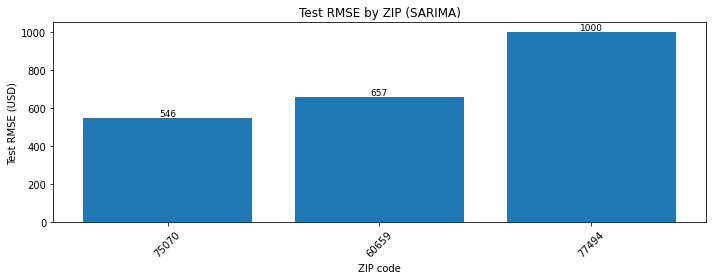

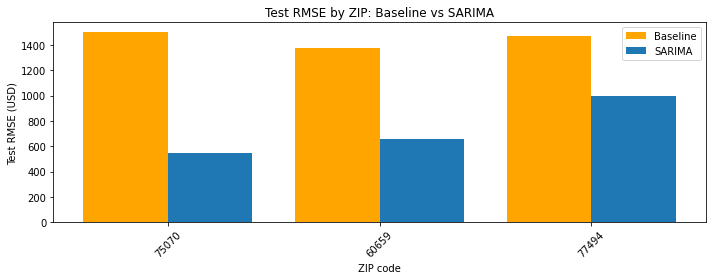

In [55]:
# --- Portfolio scan (user-selected ZIPs) ---
# Goal:
# - You choose ZIPs (comma-separated)
# - For each ZIP, compute test RMSE for Baseline vs SARIMA + next-month risk flag
# - Plot a chart where EACH BAR corresponds to ONE ROW (ONE ZIP) — not a histogram

import re  # needed for parse_zip_list

# Choose ZIP codes here (comma-separated). Example: "60659, 75070, 77494"
ZIP_LIST_TEXT = "60659, 75070, 77494"

# Material-decline threshold (e.g., -1% next month)
TAU = -0.01

# Set True to run the scan
RUN_PORTFOLIO_SCAN = True


def parse_zip_list(text):
    """Parse comma-separated ZIPs into zero-padded 5-digit strings."""
    zips = []
    for part in str(text).split(","):
        p = part.strip()
        if not p:
            continue
        # digits only (handles accidental spaces/characters)
        p = re.sub(r"[^0-9]", "", p)
        if p:
            zips.append(p.zfill(5))
    return zips


def portfolio_scan(zip_list,
                   tau=-0.01,
                   sarima_order=(1, 1, 1),
                   sarima_seasonal=(1, 0, 1, 12)):
    """Evaluate baseline vs SARIMA on the test split for a list of ZIPs."""
    results = []

    for z in zip_list:
        try:
            train, val, test = split_series_by_zip(z)
            train_f, val_f, test_f = ffill_no_leak_levels(train, val, test)

            train_log = np.log(train_f.dropna())
            val_log   = np.log(val_f.dropna())
            test_log  = np.log(test_f.dropna())

            # skip ZIPs with short history
            if len(train_log) < 36 or len(val_log) < 12 or len(test_log) < 6:
                continue

            # Baseline (test)
            y_test = np.exp(test_log)
            pred_base = persistence_forecast_test(val_f, test_f).reindex(y_test.index)

            # SARIMA: rolling 1-step on test using train+val history (fair vs baseline)
            trainval_log = pd.concat([train_log, val_log]).sort_index()
            pred_log = rolling_one_step_sarima_log(
                trainval_log, test_log, order=sarima_order, seasonal_order=sarima_seasonal
            )
            pred_sar = np.exp(pred_log)

            met_base = evaluate_regression_aligned(y_test, pred_base)
            met_sar  = evaluate_regression_aligned(y_test, pred_sar)

            # Next-month risk (forecast 1 month ahead from end of full history)
            full_log = np.log(pd.concat([train_f, val_f, test_f]).dropna())
            m = SARIMAX(
                full_log, order=sarima_order, seasonal_order=sarima_seasonal,
                enforce_stationarity=False, enforce_invertibility=False
            ).fit(disp=False)

            next_log = float(m.forecast(steps=1).iloc[0])
            next_price = float(np.exp(next_log))
            last_price = float(np.exp(full_log.iloc[-1]))
            next_ret = next_price / last_price - 1
            risk_flag = int(next_ret <= tau)

            results.append({
                "zip": z,
                "rmse_baseline": met_base["RMSE"],
                "rmse_sarima": met_sar["RMSE"],
                "rmse_improvement": met_base["RMSE"] - met_sar["RMSE"],
                "next_month_pred_ret": next_ret,
                "risk_flag_decline_le_1pct": risk_flag
            })

        except Exception:
            continue

    return pd.DataFrame(results)


if RUN_PORTFOLIO_SCAN:
    zip_list = parse_zip_list(ZIP_LIST_TEXT)

    if len(zip_list) == 0:
        print("No ZIPs provided. Add ZIPs to ZIP_LIST_TEXT and re-run.")
    else:
        portfolio_df = portfolio_scan(zip_list, tau=TAU)

        if portfolio_df.empty:
            print("No ZIPs produced results (often due to short histories or missing data). Try different ZIPs.")
        else:
            portfolio_df = portfolio_df.sort_values("rmse_sarima").reset_index(drop=True)
            display(portfolio_df)

            # --- Chart 1: ONE bar per ZIP (each bar maps to one table row) ---
            plot_df = portfolio_df.copy()

            plt.figure(figsize=(10, 4))
            plt.bar(plot_df["zip"].astype(str), plot_df["rmse_sarima"])
            plt.title("Test RMSE by ZIP (SARIMA)")
            plt.xlabel("ZIP code")
            plt.ylabel("Test RMSE (USD)")

            # Optional: show exact RMSE above each bar
            for i, v in enumerate(plot_df["rmse_sarima"].values):
                plt.text(i, v, f"{v:.0f}", ha="center", va="bottom", fontsize=9)

            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

            # --- Chart 2 (optional but useful): Baseline vs SARIMA per ZIP ---
            x = np.arange(len(plot_df))
            width = 0.4

            plt.figure(figsize=(10, 4))
            plt.bar(x - width/2, plot_df["rmse_baseline"], width, label="Baseline", color="orange")
            plt.bar(x + width/2, plot_df["rmse_sarima"],   width, label="SARIMA",)
            plt.title("Test RMSE by ZIP: Baseline vs SARIMA")
            plt.xlabel("ZIP code")
            plt.ylabel("Test RMSE (USD)")
            plt.xticks(x, plot_df["zip"].astype(str), rotation=45)
            plt.legend()
            plt.tight_layout()
            plt.show()


This histogram summarizes how forecast error varies across the ZIPs you selected. Each bar counts how many ZIPs fall into a given test RMSE range for the SARIMA model, which helps compare portfolio risk hotspots vs more stable areas.
